In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_device('cpu')

import numpy as np

from transformers_simple.fcn import FCN
from transformers_simple.train import Trainer
from transformers_simple.dataset import CharDataset

In [2]:
N = 4

block_size  = 2
embed_size  = 6
hidden_size = 30
num_layers = 3

vocab_size  = 3
input_size = block_size*embed_size
output_size = vocab_size

log_interval = 50
epochs = 5
learning_rate = 1e-4
device = torch.device('cpu')

In [3]:
# #block size 1
# data = "".join(["abca"]*1000)

In [4]:
# block size 2
data = "".join(["aabcacb"]*1000)

In [5]:
dataset = CharDataset(data=data, block_size=block_size)
dataset[0]

(tensor([0, 0]), tensor([0, 1]))

In [6]:
class AdapterNet(torch.nn.Module):
    def __init__(self, net):
        super(AdapterNet,self).__init__()
        self.net = net
        self.embedding = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)
        
    def forward(self, x):
        nb, l = x.size()

        o = self.embedding(x)
        o = o.view(nb,-1)
        o = self.net(o)

        return o
    
net = FCN(input_size=input_size, output_size=output_size, 
          hidden_size=hidden_size, num_layers=num_layers)

model = AdapterNet(net)

In [7]:
x = dataset[0][0].view(1,-1)

In [8]:
o = model(x)
o.size()

torch.Size([1, 3])

In [9]:
loss = torch.nn.CrossEntropyLoss()

def loss_fn(o,y):
    return loss(o,y[:,-1])

In [10]:
trainer = Trainer(model=model, 
                  dataset=dataset, 
                  loss_fn=loss_fn, 
                  batch_size=N, 
                  learning_rate=learning_rate,
                  epochs=epochs, 
                  log_interval=log_interval, 
                  device=device)

In [11]:
trainer.run()

Train Epoch: 0 [0/6998 (0%)]	Loss: 1.201451
Train Epoch: 0 [200/6998 (3%)]	Loss: 1.090423
Train Epoch: 0 [400/6998 (6%)]	Loss: 1.168828
Train Epoch: 0 [600/6998 (9%)]	Loss: 0.985244
Train Epoch: 0 [800/6998 (11%)]	Loss: 0.934935
Train Epoch: 0 [1000/6998 (14%)]	Loss: 1.077978
Train Epoch: 0 [1200/6998 (17%)]	Loss: 0.910065
Train Epoch: 0 [1400/6998 (20%)]	Loss: 1.074868
Train Epoch: 0 [1600/6998 (23%)]	Loss: 0.955347
Train Epoch: 0 [1800/6998 (26%)]	Loss: 0.922149
Train Epoch: 0 [2000/6998 (29%)]	Loss: 1.010395
Train Epoch: 0 [2200/6998 (31%)]	Loss: 1.159485
Train Epoch: 0 [2400/6998 (34%)]	Loss: 0.749279
Train Epoch: 0 [2600/6998 (37%)]	Loss: 0.855946
Train Epoch: 0 [2800/6998 (40%)]	Loss: 0.676294
Train Epoch: 0 [3000/6998 (43%)]	Loss: 0.757260
Train Epoch: 0 [3200/6998 (46%)]	Loss: 0.629106
Train Epoch: 0 [3400/6998 (49%)]	Loss: 0.473150
Train Epoch: 0 [3600/6998 (51%)]	Loss: 0.523753
Train Epoch: 0 [3800/6998 (54%)]	Loss: 0.248940
Train Epoch: 0 [4000/6998 (57%)]	Loss: 0.056500
Tra

Train Epoch: 4 [6600/6998 (94%)]	Loss: 0.000010
Train Epoch: 4 [6800/6998 (97%)]	Loss: 0.000015


In [13]:
x = dataset[0][0].view(1,-1)

o = model(x)

In [15]:
torch.nn.functional.softmax(o, dim=1)

tensor([[1.3423e-12, 9.9997e-01, 2.9072e-05]], grad_fn=<SoftmaxBackward0>)

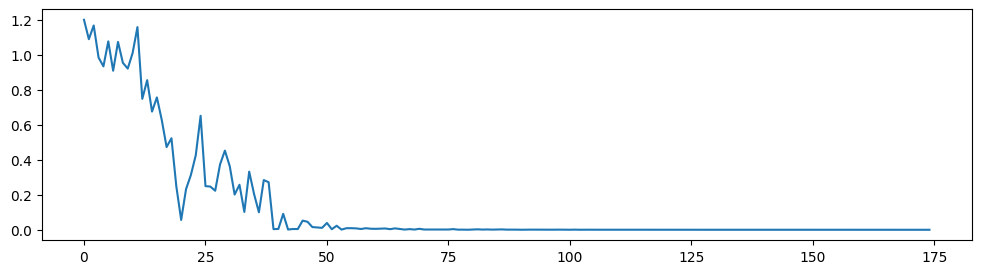

In [16]:
loss_history = trainer.loss_history

plt.figure(figsize=(12,3))
plt.plot(loss_history)
plt.show()